#MNIST classification with Vowpal Wabbit   
##PCA data

In [1]:
from __future__ import division
import re
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#%qtconsole

##Train

I found some help with parameters here: 
* https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial    
* https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments

--cache_file train.cache    
converts train_ALL.vw to a binary file for future faster processing. 
Next time we go through the model building, we will use the cache file 
and not the text file.    

--passes     
is the number of passes    

--oaa 10    
refers to oaa learning algorithm with 10 classes (1 to 10)    

-q ii    
creates interaction between variables in the two referred to namespaces 
which here are the same i.e. 'image' Namespace.   
An interaction variable is created from two variables 'A' and 'B' 
by multiplying the values of 'A' and 'B'.    

-f mnist_ALL.model    
refers to file where model will be saved.    

-b     
refers to number of bits in the feature table.   
Default number is 18 but as we have increased the number of features much more 
by introducing interaction features, value of '-b' has been increased to 22.   

-l rate   
Adjust the learning rate. Defaults to 0.5

--power_t p   
This specifies the power on the learning rate decay. You can adjust this --power_t p where p is in the range [0,1]. 0 means the learning rate does not decay, which can be helpful when state tracking, while 1 is very aggressive. Defaults to 0.5

In [3]:
!rm train.vw.cache

In [4]:
!rm pca_train.model

rm: cannot remove ‘pca_train.model’: No such file or directory


In [5]:
!vw -d data/mnist_train_pca.vw --cache_file train.vw.cache -f pca_train.model -b 19 --oaa 10 -q ii --passes 35 --early_terminate 3  -l 0.4 --power_t 0.6 --initial_t 0 --decay_learning_rate  1

creating quadratic features for pairs: ii 
final_regressor = pca_train.model
Num weight bits = 19
learning rate = 0.4
initial_t = 0
power_t = 0.6
decay_learning_rate = 1
can't open: train.vw.cache, error = No such file or directory
creating cache_file = train.vw.cache
Reading datafile = data/mnist_train_pca.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        6        1     1540
1.000000 1.000000            2            2.0        1        6     1540
1.000000 1.000000            4            4.0        2        1     1540
0.875000 0.750000            8            8.0        4        6     1540
0.812500 0.750000           16           16.0        3        4     1540
0.812500 0.812500           32           32.0        1        2     1540
0.687500 0.562500           64           64.0        2        2     1540
0.468750 0.2500

##Predict 

-t    
is for test file   

-i    
specifies the model file created earlier   

-p   
where to store the class predictions [1,10]   

In [6]:
!rm predict.txt

In [7]:
!vw -t data/mnist_test_pca.vw -i pca_train.model  -p predict.txt

only testing
predictions = predict.txt
Num weight bits = 19
learning rate = 10
initial_t = 1
power_t = 0.5
using no cache
Reading datafile = data/mnist_test_pca.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        8        8     1540
0.000000 0.000000            2            2.0        3        3     1540
0.000000 0.000000            4            4.0        1        1     1540
0.000000 0.000000            8            8.0       10       10     1540
0.000000 0.000000           16           16.0        6        6     1540
0.000000 0.000000           32           32.0        2        2     1540
0.000000 0.000000           64           64.0        4        4     1540
0.007812 0.015625          128          128.0        6        6     1540
0.011719 0.015625          256          256.0        8        8     1540
0.013672 0.015625

##Analyze

In [8]:
y_true=[]
with open("data/mnist_test_pca.vw", 'rb') as f:
    for line in f:
        m = re.search('^\d+', line)
        if m:
            found = m.group()
        y_true.append(int(found))


y_pred = []
with open("predict.txt", 'rb') as f:
    for line in f:
        m = re.search('^\d+', line)
        if m:
            found = m.group()
        y_pred.append(int(found))

target_names     = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"] # NOTE: plus one

[[1945    1    4    1    0    0    8    1    0    0]
 [   4 2252    2    0    2    3    3    1    3    0]
 [   8    4 2018    3    3    0    2    7   19    0]
 [   3    0    5 1981    0   15    0    3    8    5]
 [   1    2    3    1 1940    0    7    1    2    7]
 [   4    0    0   12    0 1761    4    0    3    0]
 [  13    5    2    1    5    8 1881    0    1    0]
 [   2   10   13    3    0    1    0 2014    4    9]
 [   8    0    4    8    2    5    5    4 1906    6]
 [   7    2    3    2   18    8    1   12    4 1961]]

Model accuracy: 0.98295, model misclass rate: 0.01705


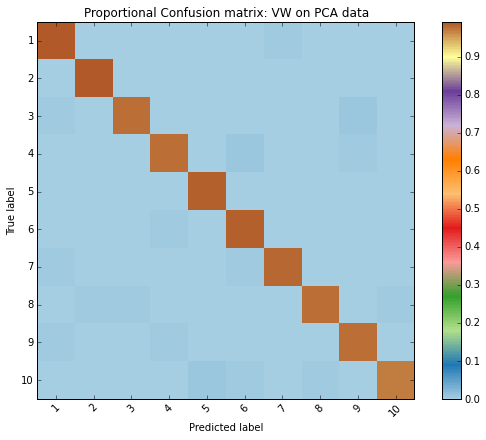

In [9]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Proportional Confusion matrix: VW on PCA data', 
                          cmap=plt.cm.Paired):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.figure(figsize=(8, 6))
    plt.imshow((cm/cm.sum(axis=1)), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(y_pred)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)